In [22]:
import create_population
import preprocessing
from feature_engineering import FeatureCreator
from feature_engineering_prediction import PredictionFeatureCreator
from train_gbm import Trainer_gbm
import prediction
from evaluation_gbm import Evaluator_gbm
from pathlib import Path
import pickle
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from sklearn.metrics import log_loss

import pandas as pd
DATA_DIR = Path("..","data")

COMMON_DATA_DIR = Path("..", "..", "common", "data")
RAWDF_DIR = COMMON_DATA_DIR / "rawdf"
import preprocessing
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload

In [3]:
population = create_population.create(from_="2022-01-01", to_="2023-12-31")

In [4]:
# レース結果テーブルの前処理
results_preprocessed = preprocessing.process_results()

In [6]:
# 馬の過去成績テーブルの加工
horse_results_preprocessed = preprocessing.process_horse_results()


In [ ]:
def process_return_tables(
    population_dir: Path = POPULATION_DIR,
    populaton_filename: str = "population.csv",
    input_dir: Path = RAWDF_DIR,
    input_filename: str = "return_tables.csv",
    output_dir: Path = OUTPUT_DIR,
    output_filename: str = "return_tables.pickle",
) -> pd.DataFrame:
    """
    未加工の払い戻しテーブルをinput_dirから読み込んで加工し、
    output_dirに保存する関数。
    """
    population = pd.read_csv(population_dir / populaton_filename, sep="\t")
    df = pd.read_csv(input_dir / input_filename, sep="\t", index_col=0).query(
        "race_id in @population['race_id']"
    )
    df = (
        df[["0", "1", "2"]]
        .replace(" (-|→) ", "-", regex=True)
        .replace(",", "", regex=True)
        .explode(["1", "2"])
        .explode("0")        
        .apply(lambda x: x.str.split())
        .apply(lambda x: x.str.split("-"))
        .explode(["0", "2"])
    )
    df.columns = ["bet_type", "win_umaban", "return"]
    df = df.query("bet_type != '枠連'").reset_index()
    df["return"] = df["return"].astype(int)
    # リスト構造を維持したいのでpickleで保存
    df.to_pickle(output_dir / output_filename)
    return df


In [13]:
raw = pd.read_csv(RAWDF_DIR/"return_tables.csv",sep="\t",index_col=0)
raw

,0,1,2,3,0.1,1.1,2.1,3.1
race_id,,,,,,,,
202206010101,NaN,NaN,NaN,NaN,単勝,15,680,4
202206010101,NaN,NaN,NaN,NaN,複勝,15 10 4,"210 1,600 170",3 13 1
202206010101,NaN,NaN,NaN,NaN,枠連,5 - 8,2680,13
202206010101,NaN,NaN,NaN,NaN,馬連,10 - 15,31040,61
202206010101,NaN,NaN,NaN,NaN,ワイド,10 - 15 4 - 15 4 - 10,"6,890 660 5,640",58 4 50
...,...,...,...,...,...,...,...,...
202309050912,NaN,NaN,NaN,NaN,馬連,2 - 12,9930,28
202309050912,NaN,NaN,NaN,NaN,ワイド,2 - 12 2 - 5 5 - 12,"2,590 1,380 460",27 15 2
202309050912,NaN,NaN,NaN,NaN,馬単,2 → 12,29610,69


# データ加工・タイムと着差とコーナー（通過）とのぼり

In [36]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(RAWDF_DIR / "results.csv",sep="\t")
df

,race_id,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id,owner_id,trainer_id,ﾀｲﾑ指数,通過,上り,調教ﾀｲﾑ,厩舎ｺﾒﾝﾄ,備考,馬主,賞金(万円)
0,202206010101,1,8,15,ニシノアナ,牝3,51.0,横山琉人,1:12.5,NaN,6.8,4.0,456(+4),[東] 相沢郁,2019103610,1192,897009,1020,**,2-2,37.6,NaN,NaN,NaN,西山茂行,520.0
1,202206010101,2,5,10,トラストパッキャオ,牝3,54.0,菅原明良,1:12.5,クビ,57.2,12.0,458(+2),[東] 高木登,2019100855,1179,125008,1088,**,1-1,37.7,NaN,NaN,NaN,菅波雅巳,210.0
2,202206010101,3,2,4,マイネルシトラス,牡3,56.0,柴田大知,1:12.5,クビ,3.7,1.0,518(-2),[東] 武市康男,2019103542,1009,546800,1089,**,4-3,37.3,NaN,NaN,NaN,サラブレッドクラブ・ラフィアン,130.0
3,202206010101,4,1,2,ピカリエ,牝3,54.0,伊藤工真,1:12.8,1.1/2,16.0,9.0,486(+6),[東] 金成貴史,2019104288,1119,64803,1132,**,10-7,37.2,NaN,NaN,NaN,リトルブルーファーム,78.0
4,202206010101,5,8,16,ブラッドライン,牡3,56.0,Ｍ．デム,1:13.2,2.1/2,10.0,5.0,478(-2),[東] 伊藤大士,2019101003,5212,427030,1109,**,4-5,38.0,NaN,NaN,NaN,前原敏行,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94887,202309050912,12,6,11,エグレムニ,牡6,58.0,松若風馬,1:09.5,3/4,172.3,13.0,512(+4),[西] 加用正,2017104873,1154,758005,425,**,15-15,33.6,NaN,NaN,NaN,吉田照哉,NaN
94888,202309050912,13,8,15,ハギノメーテル,牝4,56.0,藤懸貴志,1:09.5,1/2,94.7,12.0,498(+10),[西] 寺島良,2019100653,1138,950006,1158,**,9-11,34.2,NaN,NaN,NaN,日隈良江,NaN
94889,202309050912,14,4,7,アビエルト,牡6,58.0,和田竜二,1:09.6,1/2,75.0,10.0,508(+2),[西] 杉山佳明,2017106240,1018,258033,1178,**,5-6,34.5,NaN,NaN,NaN,野嶋祥二,NaN
94890,202309050912,15,8,16,クムシラコ,牡5,58.0,荻野琢真,1:09.8,3/4,368.3,15.0,472(-4),[東] 石毛善彦,2018103205,1112,629800,428,**,5-4,34.9,NaN,NaN,NaN,ミルファーム,NaN


In [12]:
df["time"] = pd.to_datetime(df["タイム"], format="%M:%S.%f", errors="coerce")
df.dropna(subset=["time"], inplace=True)
df["time"] = (
    df["time"].dt.minute * 60
    + df["time"].dt.second
    + df["time"].dt.microsecond / 1000000
)
df["time"].value_counts(dropna=False)


time
72.8     328
72.6     324
72.1     320
71.8     314
69.7     311
        ... 
257.8      1
257.7      1
231.7      1
232.2      1
285.3      1
Name: count, Length: 1783, dtype: int64

In [15]:
df["nobori"] = df["上り"].astype(float)
df["nobori"]

0        37.6
1        37.7
2        37.3
3        37.2
4        38.0
         ... 
94887    33.6
94888    34.2
94889    34.5
94890    34.9
94891    34.4
Name: nobori, Length: 94115, dtype: float64

In [40]:
import pandas as pd
import numpy as np
# コーナー通過順を分割して列を作成
corner_cols = df['通過'].str.split('-', expand=True)
corner_cols.columns = [f'コーナー_{i+1}' for i in range(corner_cols.shape[1])]

# 元のデータフレームと結合
result_df = pd.concat([df, corner_cols], axis=1)

# NoneをNaNに置き換え
result_df = result_df.where(pd.notnull(result_df), np.nan)

# 結果を表示
result_df


,race_id,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id,owner_id,trainer_id,ﾀｲﾑ指数,通過,上り,調教ﾀｲﾑ,厩舎ｺﾒﾝﾄ,備考,馬主,賞金(万円),コーナー_1,コーナー_2,コーナー_3,コーナー_4
0,202206010101,1,8,15,ニシノアナ,牝3,51.0,横山琉人,1:12.5,NaN,6.8,4.0,456(+4),[東] 相沢郁,2019103610,1192,897009,1020,**,2-2,37.6,NaN,NaN,NaN,西山茂行,520.0,2,2,NaN,NaN
1,202206010101,2,5,10,トラストパッキャオ,牝3,54.0,菅原明良,1:12.5,クビ,57.2,12.0,458(+2),[東] 高木登,2019100855,1179,125008,1088,**,1-1,37.7,NaN,NaN,NaN,菅波雅巳,210.0,1,1,NaN,NaN
2,202206010101,3,2,4,マイネルシトラス,牡3,56.0,柴田大知,1:12.5,クビ,3.7,1.0,518(-2),[東] 武市康男,2019103542,1009,546800,1089,**,4-3,37.3,NaN,NaN,NaN,サラブレッドクラブ・ラフィアン,130.0,4,3,NaN,NaN
3,202206010101,4,1,2,ピカリエ,牝3,54.0,伊藤工真,1:12.8,1.1/2,16.0,9.0,486(+6),[東] 金成貴史,2019104288,1119,64803,1132,**,10-7,37.2,NaN,NaN,NaN,リトルブルーファーム,78.0,10,7,NaN,NaN
4,202206010101,5,8,16,ブラッドライン,牡3,56.0,Ｍ．デム,1:13.2,2.1/2,10.0,5.0,478(-2),[東] 伊藤大士,2019101003,5212,427030,1109,**,4-5,38.0,NaN,NaN,NaN,前原敏行,52.0,4,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94887,202309050912,12,6,11,エグレムニ,牡6,58.0,松若風馬,1:09.5,3/4,172.3,13.0,512(+4),[西] 加用正,2017104873,1154,758005,425,**,15-15,33.6,NaN,NaN,NaN,吉田照哉,NaN,15,15,NaN,NaN
94888,202309050912,13,8,15,ハギノメーテル,牝4,56.0,藤懸貴志,1:09.5,1/2,94.7,12.0,498(+10),[西] 寺島良,2019100653,1138,950006,1158,**,9-11,34.2,NaN,NaN,NaN,日隈良江,NaN,9,11,NaN,NaN
94889,202309050912,14,4,7,アビエルト,牡6,58.0,和田竜二,1:09.6,1/2,75.0,10.0,508(+2),[西] 杉山佳明,2017106240,1018,258033,1178,**,5-6,34.5,NaN,NaN,NaN,野嶋祥二,NaN,5,6,NaN,NaN
94890,202309050912,15,8,16,クムシラコ,牡5,58.0,荻野琢真,1:09.8,3/4,368.3,15.0,472(-4),[東] 石毛善彦,2018103205,1112,629800,428,**,5-4,34.9,NaN,NaN,NaN,ミルファーム,NaN,5,4,NaN,NaN


In [87]:
results_preprocessed = preprocessing.process_results()

In [88]:
results_preprocessed

,race_id,horse_id,jockey_id,trainer_id,owner_id,rank,time,nobori,umaban,wakuban,tansho_odds,popularity,impost,sex,age,weight,weight_diff,corner_1,corner_2,corner_3,corner_4
27003,202201010101,2020100678,666,1066,356803,1,113.5,35.9,1,1,1.2,1,54.0,0,2,436,0,2,2,2,2
27006,202201010101,2020105743,1091,420,639009,4,114.4,37.0,2,2,17.2,4,54.0,0,2,432,-2,1,1,1,1
27004,202201010101,2020102526,1170,1005,270006,2,113.6,35.8,3,3,11.3,3,54.0,0,2,450,-6,4,2,3,4
27007,202201010101,2020102360,1144,431,970006,5,114.6,36.7,4,4,28.4,5,54.0,0,2,460,6,4,4,5,5
27005,202201010101,2020102535,1140,1005,270006,3,113.7,36.0,5,5,4.3,2,54.0,0,2,412,-6,2,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80422,202310030812,2019102542,1208,1161,17803,1,160.0,36.5,8,6,3.5,1,53.0,1,4,442,-2,4,4,2,1
80427,202310030812,2020103754,1116,1104,651031,6,162.6,38.4,9,7,15.2,8,55.0,0,3,468,0,7,7,9,6
80425,202310030812,2020100400,1193,1092,180800,4,161.8,36.9,10,7,23.1,9,50.0,1,3,458,6,11,11,12,10
80423,202310030812,2020103663,732,1092,226800,2,160.9,37.3,11,8,5.0,3,55.0,2,3,486,-6,5,5,2,2


In [89]:



print(results_preprocessed.dtypes)


race_id          int64
horse_id         int64
jockey_id        int64
trainer_id       int64
owner_id         int64
rank             int64
time           float64
nobori         float64
umaban           int64
wakuban          int64
tansho_odds    float64
popularity       int64
impost         float64
sex              int64
age              int64
weight           int64
weight_diff      int64
corner_1         Int64
corner_2         Int64
corner_3         Int64
corner_4         Int64
dtype: object


In [62]:
#重複チェック
results_preprocessed.duplicated(subset=["race_id","horse_id"]).sum()

np.int64(0)

In [63]:
#欠損チェック
results_preprocessed.isnull().sum()

race_id            0
horse_id           0
jockey_id          0
trainer_id         0
owner_id           0
rank               0
time               0
nobori             0
umaban             0
wakuban            0
tansho_odds        0
popularity         0
impost             0
sex                0
age                0
weight             0
weight_diff        0
corner_1           0
corner_2         712
corner_3       46767
corner_4       52909
dtype: int64

コーナー_1  コーナー_2  コーナー_3  コーナー_4
1       1       1       1         2178
2       2       2       2         1925
3       3       3       3          809
                2       2          348
1       1       1       2          337
                                  ... 
3       5       10      11           1
                        12           1
                        14           1
                        16           1
1       1       14      14           1
Name: count, Length: 5243, dtype: int64

In [9]:
#馬の過去成績テーブル
df = pd.read_csv(RAWDF_DIR / "horse_results.csv",sep= "\t")

In [10]:
 df

,horse_id,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,...,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴
0,2019103610,2023/11/03,門別,晴,10.0,JBCデーはSPAT,NaN,12.0,7.0,10.0,...,**,8-8,0.0-37.6,37.3,486(-8),NaN,NaN,ラビアータ,3.8,NaN
1,2019103610,2023/10/17,門別,晴,11.0,ルドベキア特別,NaN,10.0,7.0,7.0,...,**,4-3,0.0-37.3,37.2,494(+4),NaN,NaN,コイニオチテ,NaN,NaN
2,2019103610,2023/10/04,門別,晴,11.0,がんばれ!Aiba浦,NaN,10.0,6.0,6.0,...,**,5-6,0.0-37.6,37.9,490(+6),NaN,NaN,ロザシアニン,NaN,NaN
3,2019103610,2023/09/19,門別,晴,11.0,デュランタ特別,NaN,12.0,7.0,9.0,...,**,5-5,0.0-36.5,37.3,484(+4),NaN,NaN,ルクスディオン,NaN,NaN
4,2019103610,2023/09/05,門別,晴,11.0,江差追分全国大会特別,NaN,11.0,1.0,1.0,...,**,4-4,0.0-37.4,36.9,480(-4),NaN,NaN,コイニオチテ,11.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305467,2021103807,2024/04/10,名古屋,晴,2.0,3歳5組,NaN,12.0,7.0,10.0,...,**,2-2-4,0.0-39.5,40.9,455(0),NaN,NaN,コープスリバイバー,8.1,NaN
305468,2021103807,2024/03/29,名古屋,晴,3.0,3歳8組,NaN,11.0,3.0,3.0,...,**,2-2-1,0.0-40.9,41.3,455(-3),NaN,NaN,カルテメトレス,17.5,NaN
305469,2021103807,2024/02/24,1阪神1,曇,2.0,3歳未勝利,NaN,11.0,1.0,1.0,...,**,1-1-1-2,36.8-39.7,43.0,458(+2),NaN,NaN,ギマール,NaN,NaN
305470,2021103807,2024/01/13,1京都4,晴,2.0,3歳未勝利,NaN,14.0,2.0,2.0,...,**,14-12-9-8,35.8-39.8,40.8,456(+2),NaN,NaN,ハッピーマインド,NaN,NaN


In [17]:
import json
from pathlib import Path

import pandas as pd
import numpy as np

COMMON_DATA_DIR = Path("..", "..", "common", "data")
RAWDF_DIR = COMMON_DATA_DIR / "rawdf"
MAPPING_DIR = COMMON_DATA_DIR / "mapping"
POPULATION_DIR = Path("..", "data", "00_population")
OUTPUT_DIR = Path("..", "data", "01_preprocessed")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# カテゴリ変数を数値に変換するためのマッピング
with open(MAPPING_DIR / "sex.json", "r") as f:
    sex_mapping = json.load(f)
with open(MAPPING_DIR / "race_type.json", "r") as f:
    race_type_mapping = json.load(f)
with open(MAPPING_DIR / "around.json", "r") as f:
    around_mapping = json.load(f)
with open(MAPPING_DIR / "weather.json", "r") as f:
    weather_mapping = json.load(f)
with open(MAPPING_DIR / "ground_state.json", "r") as f:
    ground_state_mapping = json.load(f)
with open(MAPPING_DIR / "race_class.json", "r") as f:
    race_class_mapping = json.load(f)
with open(MAPPING_DIR / "place.json", "r") as f:
    place_mapping = json.load(f)

    regex_race_class = "|".join(race_class_mapping)
    df["race_class"] = (
        df["レース名"].str.extract(rf"({regex_race_class})")[0].map(race_class_mapping)
    )

In [19]:
# 特定の文字を含む行を抽出
import pandas as pd
G = "GI"
filtered_df = df[df['レース名'].str.contains(G,case=False)]
filtered_df 

,horse_id,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,...,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴,race_class
130,2019101408,2024/10/06,4東京2,曇,11.0,毎日王冠(GII),NaN,14.0,3.0,3.0,...,9-10-9,35.3-33.7,33.6,534(+10),NaN,NaN,シックスペンス,NaN,NaN,7.0
131,2019101408,2024/06/09,3東京4,曇,11.0,エプソムC(GIII),NaN,18.0,8.0,17.0,...,3-6-5,35.2-34.6,34.1,524(-8),NaN,NaN,レーベンスティール,1718.2,NaN,6.0
132,2019101408,2024/03/30,3中山3,晴,11.0,ダービー卿チャレンジ(GIII),NaN,16.0,6.0,11.0,...,10-9-7,35.5-35.1,33.9,532(-6),NaN,NaN,パラレルヴィジョン,620.0,NaN,6.0
145,2019101408,2022/04/16,2阪神7,晴,11.0,アーリントンC(GIII),NaN,18.0,3.0,5.0,...,17-17,34.3-34.2,33.9,514(-8),NaN,NaN,ダノンスコーピオン,NaN,NaN,6.0
1581,2019104706,2023/06/25,3阪神8,曇,11.0,宝塚記念(GI),NaN,17.0,6.0,12.0,...,4-5-4-3,34.0-35.5,36.5,480(-2),NaN,NaN,イクイノックス,NaN,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305175,2021103678,2024/04/21,2東京2,曇,11.0,サンスポ賞フローラS(GII),NaN,14.0,7.0,11.0,...,2-2-2,35.6-35.0,35.8,462(-2),NaN,NaN,アドマイヤベル,NaN,NaN,7.0
305235,2021105449,2024/04/21,2東京2,曇,11.0,サンスポ賞フローラS(GII),NaN,14.0,7.0,12.0,...,7-7-6,35.6-35.0,35.0,470(0),NaN,NaN,アドマイヤベル,NaN,NaN,7.0
305389,2021105117,2024/05/04,3京都5,晴,11.0,京都新聞杯(GII),NaN,15.0,5.0,8.0,...,3-5-4-8,35.7-33.8,36.2,474(-4),NaN,NaN,ジューンテイク,NaN,NaN,7.0
305390,2021105117,2024/03/23,2阪神1,曇,11.0,毎日杯(GIII),NaN,10.0,3.0,3.0,...,4-4,35.2-34.4,35.1,478(+2),NaN,NaN,メイショウタバル,1005.1,NaN,6.0


In [16]:
# 特定の文字を含む行を抽出
import pandas as pd
G = "GI"
filtered_df = df[df['レース名'].str.contains(G,case=False)]
filtered_df 

,horse_id,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,...,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴
130,2019101408,2024/10/06,4東京2,曇,11.0,毎日王冠(GII),NaN,14.0,3.0,3.0,...,**,9-10-9,35.3-33.7,33.6,534(+10),NaN,NaN,シックスペンス,NaN,NaN
131,2019101408,2024/06/09,3東京4,曇,11.0,エプソムC(GIII),NaN,18.0,8.0,17.0,...,**,3-6-5,35.2-34.6,34.1,524(-8),NaN,NaN,レーベンスティール,1718.2,NaN
132,2019101408,2024/03/30,3中山3,晴,11.0,ダービー卿チャレンジ(GIII),NaN,16.0,6.0,11.0,...,**,10-9-7,35.5-35.1,33.9,532(-6),NaN,NaN,パラレルヴィジョン,620.0,NaN
145,2019101408,2022/04/16,2阪神7,晴,11.0,アーリントンC(GIII),NaN,18.0,3.0,5.0,...,**,17-17,34.3-34.2,33.9,514(-8),NaN,NaN,ダノンスコーピオン,NaN,NaN
1581,2019104706,2023/06/25,3阪神8,曇,11.0,宝塚記念(GI),NaN,17.0,6.0,12.0,...,**,4-5-4-3,34.0-35.5,36.5,480(-2),NaN,NaN,イクイノックス,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305175,2021103678,2024/04/21,2東京2,曇,11.0,サンスポ賞フローラS(GII),NaN,14.0,7.0,11.0,...,**,2-2-2,35.6-35.0,35.8,462(-2),NaN,NaN,アドマイヤベル,NaN,NaN
305235,2021105449,2024/04/21,2東京2,曇,11.0,サンスポ賞フローラS(GII),NaN,14.0,7.0,12.0,...,**,7-7-6,35.6-35.0,35.0,470(0),NaN,NaN,アドマイヤベル,NaN,NaN
305389,2021105117,2024/05/04,3京都5,晴,11.0,京都新聞杯(GII),NaN,15.0,5.0,8.0,...,**,3-5-4-8,35.7-33.8,36.2,474(-4),NaN,NaN,ジューンテイク,NaN,NaN
305390,2021105117,2024/03/23,2阪神1,曇,11.0,毎日杯(GIII),NaN,10.0,3.0,3.0,...,**,4-4,35.2-34.4,35.1,478(+2),NaN,NaN,メイショウタバル,1005.1,NaN


In [71]:
import pandas as pd
import numpy as np
# コーナー通過順を分割して列を作成
corner_cols = df['ペース'].str.split('-', expand=True)
corner_cols.columns = [f'pase_{i+1}' for i in range(corner_cols.shape[1])]

# 元のデータフレームと結合
result_df = pd.concat([df, corner_cols], axis=1)

# NoneをNaNに置き換え
result_df = result_df.where(pd.notnull(result_df), np.nan)

# 結果を表示
result_df


,horse_id,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,人気,着順,騎手,斤量,距離,馬場,馬場指数,タイム,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金,受賞歴,pase_1,pase_2
0,2019103610,2023/11/03,門別,晴,10.0,JBCデーはSPAT,NaN,12.0,7.0,10.0,28.1,6.0,5,服部茂史,55.0,ダ1000,稍,**,1:02.6,0.9,**,8-8,0.0-37.6,37.3,486(-8),NaN,NaN,ラビアータ,3.8,NaN,0.0,37.6
1,2019103610,2023/10/17,門別,晴,11.0,ルドベキア特別,NaN,10.0,7.0,7.0,29.6,6.0,6,服部茂史,55.0,ダ1000,稍,**,1:01.9,1.0,**,4-3,0.0-37.3,37.2,494(+4),NaN,NaN,コイニオチテ,NaN,NaN,0.0,37.3
2,2019103610,2023/10/04,門別,晴,11.0,がんばれ!Aiba浦,NaN,10.0,6.0,6.0,13.4,6.0,6,服部茂史,55.0,ダ1000,良,**,1:02.2,0.9,**,5-6,0.0-37.6,37.9,490(+6),NaN,NaN,ロザシアニン,NaN,NaN,0.0,37.6
3,2019103610,2023/09/19,門別,晴,11.0,デュランタ特別,NaN,12.0,7.0,9.0,16.6,5.0,8,服部茂史,55.0,ダ1000,稍,**,1:01.4,1.7,**,5-5,0.0-36.5,37.3,484(+4),NaN,NaN,ルクスディオン,NaN,NaN,0.0,36.5
4,2019103610,2023/09/05,門別,晴,11.0,江差追分全国大会特別,NaN,11.0,1.0,1.0,16.9,4.0,3,服部茂史,55.0,ダ1000,不,**,1:01.6,0.3,**,4-4,0.0-37.4,36.9,480(-4),NaN,NaN,コイニオチテ,11.6,NaN,0.0,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305467,2021103807,2024/04/10,名古屋,晴,2.0,3歳5組,NaN,12.0,7.0,10.0,4.0,2.0,4,大畑慧悟,55.0,ダ1500,重,**,1:40.1,1.4,**,2-2-4,0.0-39.5,40.9,455(0),NaN,NaN,コープスリバイバー,8.1,NaN,0.0,39.5
305468,2021103807,2024/03/29,名古屋,晴,3.0,3歳8組,NaN,11.0,3.0,3.0,3.4,2.0,2,加藤誓二,56.0,ダ1500,不,**,1:38.6,0.4,**,2-2-1,0.0-40.9,41.3,455(-3),NaN,NaN,カルテメトレス,17.5,NaN,0.0,40.9
305469,2021103807,2024/02/24,1阪神1,曇,2.0,3歳未勝利,NaN,11.0,1.0,1.0,210.0,11.0,11,松若風馬,57.0,ダ1800,稍,**,1:58.9,3.4,**,1-1-1-2,36.8-39.7,43.0,458(+2),NaN,NaN,ギマール,NaN,NaN,36.8,39.7
305470,2021103807,2024/01/13,1京都4,晴,2.0,3歳未勝利,NaN,14.0,2.0,2.0,172.8,12.0,11,小崎綾也,57.0,ダ1800,良,**,1:57.9,2.1,**,14-12-9-8,35.8-39.8,40.8,456(+2),NaN,NaN,ハッピーマインド,NaN,NaN,35.8,39.8


In [92]:
process_horse_results = preprocessing.process_horse_results()
process_horse_results

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses,time,win,rentai,show,place,pase_1,pase_2
0,2019103610,2023-11-03,5.0,3.8,0.9,1.0,0,1000,2.0,NaN,12.0,62.6,0,0,0,NaN,0.0,37.6
1,2019103610,2023-10-17,6.0,0.0,1.0,1.0,0,1000,2.0,NaN,10.0,61.9,0,0,0,NaN,0.0,37.3
2,2019103610,2023-10-04,6.0,0.0,0.9,1.0,0,1000,0.0,NaN,10.0,62.2,0,0,0,NaN,0.0,37.6
3,2019103610,2023-09-19,8.0,0.0,1.7,1.0,0,1000,2.0,NaN,12.0,61.4,0,0,0,NaN,0.0,36.5
4,2019103610,2023-09-05,3.0,11.6,0.3,1.0,0,1000,3.0,NaN,11.0,61.6,0,0,1,NaN,0.0,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305467,2021103807,2024-04-10,4.0,8.1,1.4,1.0,0,1500,1.0,NaN,12.0,100.1,0,0,0,NaN,0.0,39.5
305468,2021103807,2024-03-29,2.0,17.5,0.4,1.0,0,1500,3.0,NaN,11.0,98.6,0,1,1,NaN,0.0,40.9
305469,2021103807,2024-02-24,11.0,0.0,3.4,2.0,0,1800,2.0,1.0,11.0,118.9,0,0,0,9.0,36.8,39.7
305470,2021103807,2024-01-13,11.0,0.0,2.1,1.0,0,1800,0.0,1.0,14.0,117.9,0,0,0,8.0,35.8,39.8


In [94]:
print(process_horse_results.dtypes)

horse_id                 int64
date            datetime64[ns]
rank                   float64
prize                  float64
rank_diff              float64
weather                float64
race_type                int64
course_len               int64
ground_state           float64
race_class             float64
n_horses               float64
time                   float64
win                      int64
rentai                   int64
show                     int64
place                  float64
pase_1                 float64
pase_2                 float64
dtype: object


In [95]:
race_info = preprocessing.process_race_info()

In [96]:
race_info

,race_id,date,race_type,around,course_len,weather,ground_state,race_class,place
0,202206010101,2022-01-05,0,0.0,1200,1,0,1,6
1,202206010102,2022-01-05,0,0.0,1800,1,0,1,6
2,202206010103,2022-01-05,0,0.0,1800,1,0,1,6
3,202206010104,2022-01-05,0,0.0,1800,1,0,0,6
4,202206010105,2022-01-05,1,0.0,2000,1,0,2,6
...,...,...,...,...,...,...,...,...,...
6907,202309050908,2023-12-28,0,0.0,1400,1,0,2,9
6908,202309050909,2023-12-28,0,0.0,1800,1,0,3,9
6909,202309050910,2023-12-28,1,0.0,2000,1,0,3,9
6910,202309050911,2023-12-28,0,0.0,1800,1,0,5,9


In [97]:
fc = FeatureCreator()

In [99]:
fc.results

,race_id,horse_id,jockey_id,trainer_id,owner_id,rank,time,nobori,umaban,wakuban,tansho_odds,popularity,impost,sex,age,weight,weight_diff,corner_1,corner_2,corner_3,corner_4
0,202201010101,2020100678,666,1066,356803,1,113.5,35.9,1,1,1.2,1,54.0,0,2,436,0,2,2.0,2.0,2.0
1,202201010101,2020105743,1091,420,639009,4,114.4,37.0,2,2,17.2,4,54.0,0,2,432,-2,1,1.0,1.0,1.0
2,202201010101,2020102526,1170,1005,270006,2,113.6,35.8,3,3,11.3,3,54.0,0,2,450,-6,4,2.0,3.0,4.0
3,202201010101,2020102360,1144,431,970006,5,114.6,36.7,4,4,28.4,5,54.0,0,2,460,6,4,4.0,5.0,5.0
4,202201010101,2020102535,1140,1005,270006,3,113.7,36.0,5,5,4.3,2,54.0,0,2,412,-6,2,4.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94108,202310030812,2019102542,1208,1161,17803,1,160.0,36.5,8,6,3.5,1,53.0,1,4,442,-2,4,4.0,2.0,1.0
94109,202310030812,2020103754,1116,1104,651031,6,162.6,38.4,9,7,15.2,8,55.0,0,3,468,0,7,7.0,9.0,6.0
94110,202310030812,2020100400,1193,1092,180800,4,161.8,36.9,10,7,23.1,9,50.0,1,3,458,6,11,11.0,12.0,10.0
94111,202310030812,2020103663,732,1092,226800,2,160.9,37.3,11,8,5.0,3,55.0,2,3,486,-6,5,5.0,2.0,2.0


In [100]:
#特徴量作成
features = fc.create_features()

agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_sire()...
merging all features...


In [101]:
features

,race_id,date,horse_id,jockey_id,trainer_id,owner_id,rank,time,nobori,umaban,wakuban,tansho_odds,popularity,impost,sex,age,weight,weight_diff,corner_1,corner_2,corner_3,corner_4,race_type,around,course_len,weather,ground_state,race_class,place,rank_3races,prize_3races,rank_5races,prize_5races,rank_10races,prize_10races,rank_1000races,prize_1000races,rank_mean_2races_relative,rank_median_2races_relative,rank_max_2races_relative,rank_min_2races_relative,prize_mean_2races_relative,prize_median_2races_relative,prize_max_2races_relative,prize_min_2races_relative,rank_diff_mean_2races_relative,rank_diff_median_2races_relative,rank_diff_max_2races_relative,rank_diff_min_2races_relative,race_class_mean_2races_relative,race_class_median_2races_relative,race_class_max_2races_relative,race_class_min_2races_relative,rank_mean_3races_relative,rank_median_3races_relative,rank_max_3races_relative,rank_min_3races_relative,prize_mean_3races_relative,prize_median_3races_relative,prize_max_3races_relative,prize_min_3races_relative,rank_diff_mean_3races_relative,rank_diff_median_3races_relative,rank_diff_max_3races_relative,rank_diff_min_3races_relative,race_class_mean_3races_relative,race_class_median_3races_relative,race_class_max_3races_relative,race_class_min_3races_relative,rank_mean_5races_relative,rank_median_5races_relative,rank_max_5races_relative,rank_min_5races_relative,prize_mean_5races_relative,prize_median_5races_relative,prize_max_5races_relative,prize_min_5races_relative,rank_diff_mean_5races_relative,rank_diff_median_5races_relative,rank_diff_max_5races_relative,rank_diff_min_5races_relative,race_class_mean_5races_relative,race_class_median_5races_relative,race_class_max_5races_relative,race_class_min_5races_relative,rank_mean_10races_relative,rank_median_10races_relative,rank_max_10races_relative,rank_min_10races_relative,prize_mean_10races_relative,prize_median_10races_relative,prize_max_10races_relative,prize_min_10races_relative,rank_diff_mean_10races_relative,rank_diff_median_10races_relative,rank_diff_max_10races_relative,rank_diff_min_10races_relative,race_class_mean_10races_relative,race_class_median_10races_relative,race_class_max_10races_relative,race_class_min_10races_relative,rank_mean_1000races_relative,rank_median_1000races_relative,rank_max_1000races_relative,rank_min_1000races_relative,prize_mean_1000races_relative,prize_median_1000races_relative,prize_max_1000races_relative,prize_min_1000races_relative,rank_diff_mean_1000races_relative,rank_diff_median_1000races_relative,rank_diff_max_1000races_relative,rank_diff_min_1000races_relative,race_class_mean_1000races_relative,race_class_median_1000races_relative,race_class_max_1000races_relative,race_class_min_1000races_relative,jockey_rank_relative,jockey_n_races_relative,jockey_n_races_graded_relative,jockey_winrate_graded_relative,jockey_n_races_special_relative,jockey_winrate_special_relative,jockey_n_races_ordinal_relative,jockey_winrate_ordinal_relative,jockey_n_races_turf_relative,jockey_winrate_turf_relative,jockey_n_races_dirt_relative,jockey_winrate_dirt_relative,jockey_winrate_relative,jockey_placerate_relative,jockey_showrate_relative,jockey_prize_relative,trainer_rank_relative,trainer_n_races_relative,trainer_n_races_graded_relative,trainer_winrate_graded_relative,trainer_n_races_special_relative,trainer_winrate_special_relative,trainer_n_races_ordinal_relative,trainer_winrate_ordinal_relative,trainer_n_races_turf_relative,trainer_winrate_turf_relative,trainer_n_races_dirt_relative,trainer_winrate_dirt_relative,trainer_winrate_relative,trainer_placerate_relative,trainer_showrate_relative,trainer_prize_relative,rank_mean_1races_per_course_len_relative,rank_min_1races_per_course_len_relative,prize_mean_1races_per_course_len_relative,prize_min_1races_per_course_len_relative,rank_diff_mean_1races_per_course_len_relative,rank_diff_min_1races_per_course_len_relative,time_mean_1races_per_course_len_relative,time_min_1races_per_course_len_relative,win_mean_1races_

# ライトGBM

In [104]:
DATA_DIR = Path("..", "data")
INPUT_DIR = DATA_DIR / "02_features"
OUTPUT_DIR = DATA_DIR / "03_train"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [115]:
features.columns

Index(['race_id', 'date', 'horse_id', 'jockey_id', 'trainer_id', 'owner_id',
       'rank', 'time', 'nobori', 'umaban',
       ...
       'win_mean_20races_per_race_type_relative',
       'win_max_20races_per_race_type_relative',
       'win_min_20races_per_race_type_relative',
       'show_mean_20races_per_race_type_relative',
       'show_max_20races_per_race_type_relative',
       'show_min_20races_per_race_type_relative', 'sire_n_races_relative',
       'sire_n_wins_relative', 'sire_winrate_relative',
       'sire_course_len_diff_relative'],
      dtype='object', length=549)

In [301]:
feature_cols = ['horse_id',
'jockey_id',
'trainer_id',
'umaban',
'wakuban',
'popularity', 
'tansho_odds',
'impost',
'sex',
'age',
'weight',
'weight_diff',
'race_type',
'around',
'course_len',
'weather',
'ground_state',
'race_class',
'place',
'rank_3races',
'prize_3races',
'rank_5races',
'prize_5races',
'rank_10races',
'prize_10races',
'rank_1000races',
'prize_1000races',
                


]

In [307]:
X = features[feature_cols]

In [243]:
y = features["rank"]


In [308]:
features["target"] = features["time"]
# features["target"] = (features["rank"]==1).astype(int)

In [309]:
train_df = features.query("date < '2023-01-01'")
test_df = features.query("date >= '2023-01-01'")


In [310]:
len(train_df),len(test_df)


(46840, 47273)

In [20]:
train_df = features.query("date <= '2022-09-31'")
valid_df = features.query("'2022-10-01'<= date < '2023-01-01'")
test_df = features.query("date >= '2023-01-01'")
len(train_df),len(valid_df),llen(test_df)


NameError: name 'features' is not defined

In [295]:
# 数値型の列のみを選択して相関行列を計算
#correlation = features.select_dtypes(include=[np.number]).corr()

# 目的変数との相関を表示
#print(correlation["target"].sort_values(ascending=False))


target        1.000000
time          1.000000
course_len    0.978655
race_type     0.344768
impost        0.312590
                ...   
corner_1     -0.063840
umaban       -0.081766
sex          -0.089827
horse_id     -0.159696
nobori       -0.429647
Name: target, Length: 549, dtype: float64


In [311]:
lgb_train = lgb.Dataset(
    train_df[feature_cols],train_df["target"]
)
lgb_test = lgb.Dataset(
    test_df[feature_cols],test_df["target"]
)

params = {
    "objective": "regression",  # 回帰問題に変更
    "metric": "mse",  # 評価指標をMean Squared Errorに変更
    "random_state": 100,
    "verbosity": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "learning_rate": 0.01,
    "bagging_freq": 1,
}
model = lgb.train(
    params = params,
    train_set = lgb_train,
    valid_sets=[lgb_train,lgb_test],
    callbacks = [lgb.log_evaluation()],
)

[1]	training's l2: 819.797	valid_1's l2: 831.647
[2]	training's l2: 803.769	valid_1's l2: 815.439
[3]	training's l2: 796.945	valid_1's l2: 808.549
[4]	training's l2: 781.294	valid_1's l2: 792.796
[5]	training's l2: 766.035	valid_1's l2: 777.363
[6]	training's l2: 751.071	valid_1's l2: 762.236
[7]	training's l2: 736.358	valid_1's l2: 747.37
[8]	training's l2: 721.909	valid_1's l2: 732.829
[9]	training's l2: 707.768	valid_1's l2: 718.543
[10]	training's l2: 693.916	valid_1's l2: 704.552
[11]	training's l2: 688.128	valid_1's l2: 698.818
[12]	training's l2: 674.668	valid_1's l2: 685.217
[13]	training's l2: 661.533	valid_1's l2: 671.93
[14]	training's l2: 648.595	valid_1's l2: 658.858
[15]	training's l2: 643.413	valid_1's l2: 653.66
[16]	training's l2: 630.834	valid_1's l2: 640.957
[17]	training's l2: 618.513	valid_1's l2: 628.507
[18]	training's l2: 606.476	valid_1's l2: 616.329
[19]	training's l2: 594.606	valid_1's l2: 604.412
[20]	training's l2: 582.987	valid_1's l2: 592.674
[21]	trainin

In [321]:
# 予測を含む評価用データフレームを作成
evaluation_df = test_df[
    [
        "race_id",
        "horse_id",
        "target",  # 目的変数の時間
        "rank",    # 実際の順位
        "tansho_odds",  # 単勝オッズ
        "popularity",    # 人気
    ]
].copy()

In [322]:
# モデルで予測したタイムを追加
evaluation_df["pred"] = model.predict(test_df[feature_cols])


In [323]:
# レースごとに昇順に並べ、最上位の馬を選ぶ
bet_df4 = (
    evaluation_df
    .sort_values(by=["race_id", "pred"])  # race_idでグルーピングし、predで昇順にソート
    .groupby("race_id")
    .head(1)  # 各レースで予測タイムが最も良い馬を選択
)

In [324]:
# 的中率の計算
hit_rate = (bet_df4["rank"] == 1).mean()  # 予測が1位の的中率
hit_rate

np.float64(0.11631944444444445)

In [332]:
# 回収率の計算
# 的中した場合のオッズの合計と、コストを算出
return_ = (bet_df["rank"] == 1).sum() + bet_df["tansho_odds"].sum()  # 的中した馬のオッズの合計
cost = len(bet_df)  # ベット数
recovery_rate = return_ / cost if cost > 0 else 0  # 回収率
cost

3456

In [327]:
# 結果を表示
print(f"的中率: {hit_rate:.2%}")  # %形式で表示
print(f"回収率: {recovery_rate:.2f}")  # 小数点形式で表示

的中率: 11.63%
回収率: 90.12


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

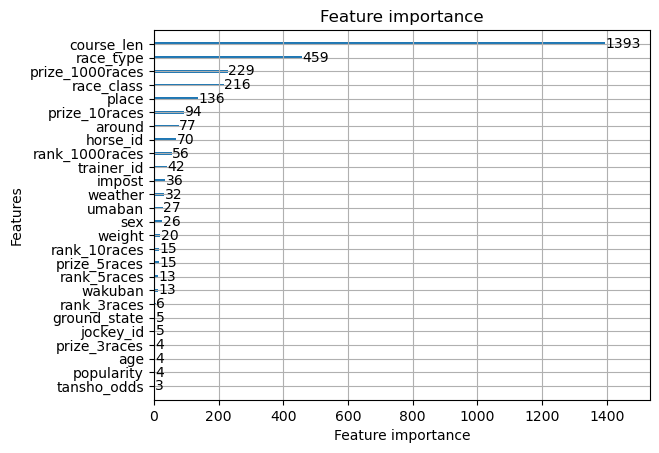

In [333]:
lgb.plot_importance(model)

In [312]:
model.predict(test_df[feature_cols])

array([85.87487166, 85.36403861, 85.39247596, ..., 84.71497324,
       84.22709996, 84.21051944])

In [313]:
evaluation_df = test_df[
    [
        "race_id",
        "horse_id",
        "target",
        "rank",
        "tansho_odds",
        "popularity",

    ]
].copy()
evaluation_df 

,race_id,horse_id,target,rank,tansho_odds,popularity
46840,202306010101,2020103575,72.6,1,1.8,1
46841,202306010101,2020107073,72.9,2,7.4,3
46842,202306010101,2020102562,72.9,3,36.1,6
46843,202306010101,2020106345,73.4,4,4.2,2
46844,202306010101,2020100039,73.9,5,7.9,4
...,...,...,...,...,...,...
94108,202309050912,2017104873,69.5,12,172.3,13
94109,202309050912,2019100653,69.5,13,94.7,12
94110,202309050912,2017106240,69.6,14,75.0,10
94111,202309050912,2018103205,69.8,15,368.3,15


In [314]:
evaluation_df["pred"] = model.predict(
    test_df[feature_cols]
)

In [315]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
46840,202306010101,2020103575,72.6,1,1.8,1,85.874872
46841,202306010101,2020107073,72.9,2,7.4,3,85.364039
46842,202306010101,2020102562,72.9,3,36.1,6,85.392476
46843,202306010101,2020106345,73.4,4,4.2,2,85.113962
46844,202306010101,2020100039,73.9,5,7.9,4,85.040917
...,...,...,...,...,...,...,...
94108,202309050912,2017104873,69.5,12,172.3,13,84.279632
94109,202309050912,2019100653,69.5,13,94.7,12,83.519572
94110,202309050912,2017106240,69.6,14,75.0,10,84.714973
94111,202309050912,2018103205,69.8,15,368.3,15,84.227100


In [318]:
bet_df = (
    evaluation_df
    .sort_values("pred",ascending=False)
    .groupby("race_id")
    .head(1)
)
bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
93187,202306050710,2012103532,282.8,7,19.2,7,212.449037
60923,202306030711,2017100997,297.5,4,9.6,4,212.449037
56363,202309010908,2016103444,263.0,3,2.2,1,211.052459
65047,202308010708,2016100158,273.7,1,2.0,1,207.763589
90195,202306050108,2016103252,243.5,9,12.3,5,192.499994
...,...,...,...,...,...,...,...
62730,202304010106,2020106716,58.6,13,33.4,9,74.129771
64721,202304010509,2020105895,56.4,12,12.0,4,74.129771
65188,202304010607,2020101434,55.9,2,2.1,1,74.110167
84601,202304040305,2021102054,58.0,1,8.9,5,74.013010


In [319]:
#的中率
bet_df["target"].mean()

np.float64(104.75517939814816)

In [320]:
#帰ってくる金額
return_ = ((bet_df["target"]==1) + bet_df["tansho_odds"]).sum()
return_

np.float64(311229.5)

In [287]:
#かけた金額
cost = len(bet_df)
cost

3456

In [288]:
#回収率
return_ = ((bet_df["target"]==1) + bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ /cost

np.float64(6.65005787037037)

In [257]:
#一番人気に対して
bet_df2 = (
    evaluation_df
    .sort_values("popularity")
    .groupby("race_id")
    .head(1)
)
bet_df2

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred
46840,202306010101,2020103575,1,1,1.8,1,14,0.082932
80225,202306040202,2021106561,1,1,2.0,1,1,0.200026
92351,202307040511,2020104304,1,1,1.9,1,13,0.135602
56587,202306020612,2019101263,0,5,2.9,1,2,0.096922
50132,202310010407,2020102661,0,4,2.6,1,5,0.220453
...,...,...,...,...,...,...,...,...
91956,202309050409,2018110137,0,2,3.0,2,1,0.130537
74319,202303020801,2017105402,0,3,3.9,2,11,0.148334
74856,202304020104,2016102442,0,9,3.6,2,4,0.090116
78633,202304030602,2020103801,0,13,6.5,2,14,0.073865


In [258]:
#的中率
bet_df2["target"].mean()

np.float64(0.3315972222222222)

In [259]:
#回収率
return_ = ((bet_df2["target"]==1) + bet_df2["tansho_odds"]).sum()
cost = len(bet_df2)
return_ /cost

np.float64(2.994878472222222)

In [260]:
#一番人気じゃないもの
bet_df3 = (
    evaluation_df
    .sort_values("popularity")
    .groupby("race_id")
    .head(1)
    .query("popularity != 1")
)
bet_df3

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred
63595,202308010411,2019105346,1,1,4.3,2,1,0.119135
63626,202304010301,2017100316,1,1,6.5,2,9,0.065504
67512,202309030102,2020102664,1,1,2.9,2,12,0.102470
59691,202303010108,2019104660,0,2,5.9,2,9,0.116169
88895,202303030604,2018105575,1,1,4.0,2,12,0.095776
67217,202308011204,2019109053,0,2,4.0,2,3,0.149477
68487,202302010202,2020104518,0,2,4.0,2,3,0.131553
91956,202309050409,2018110137,0,2,3.0,2,1,0.130537
74319,202303020801,2017105402,0,3,3.9,2,11,0.148334
74856,202304020104,2016102442,0,9,3.6,2,4,0.090116


In [261]:
#的中率
bet_df3["target"].mean()

np.float64(0.3333333333333333)

In [262]:
#回収率
return_ = ((bet_df3["target"]==1) + bet_df3["tansho_odds"]).sum()
cost = len(bet_df3)
return_ /cost

np.float64(4.758333333333334)

# 重要度

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

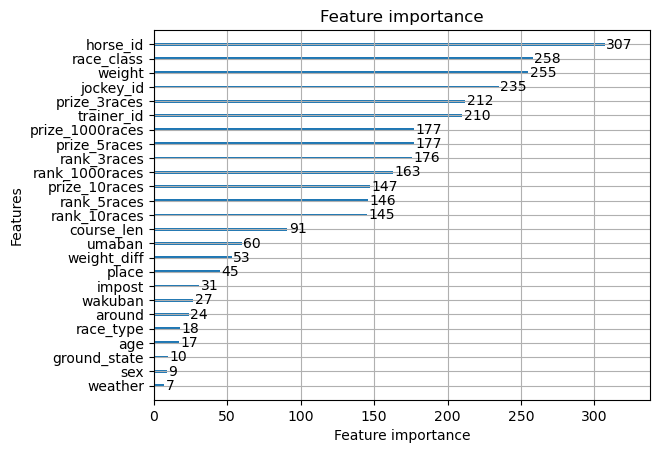

In [263]:
lgb.plot_importance(model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

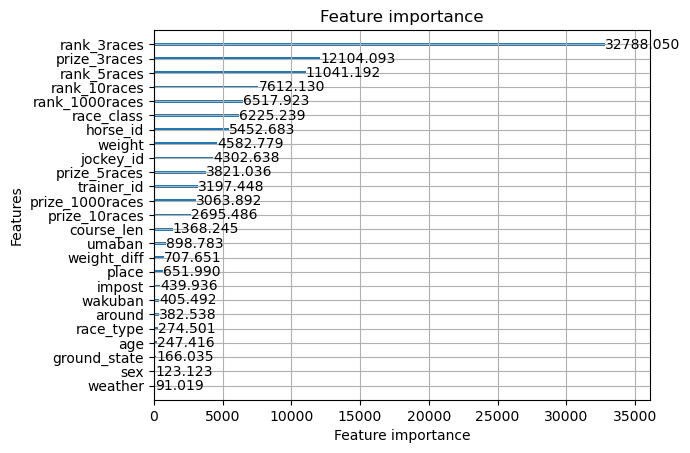

In [264]:
lgb.plot_importance(model,importance_type="gain")